In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import time
import random
import concurrent.futures
from tqdm import tqdm as tqdm_progress
from data_preprocess import parse_mnist

# 加载数据
data_images = parse_mnist(minst_file_addr="./train-images-idx3-ubyte.gz", flatten=True)


$$ \min_{\phi,s} \frac{1}{2}\| x_i - \phi s_i \|_2^2 + \alpha\|s_i\|_1 + \frac{1}{2}\beta\|\phi\|_2^2$$

In [2]:
# 28 * 28 = 768
# data: [n_samples, n_dim]
def compute_sparse_matrix(data : np.ndarray, n_feature, alpha = 0.1, beta = 300):
    n_samples = data.shape[0]
    n_dim = data.shape[1]
    Phi = np.random.random((n_dim, n_feature))
    s = np.zeros((n_samples, n_feature))

    clf = linear_model.Lasso(alpha=alpha)

    for _ in range(10):
        # print("1")
        for i in range(n_samples):
          clf.fit(Phi, data[i])
          s[i] = clf.coef_  
      
        for _ in range(20):
            step2 = 10
            dPhi = np.zeros((n_dim, n_feature))
            for i in range(n_samples):
                dxdPhi_i = -s[i].reshape(1, n_feature).repeat(n_dim, axis=0)
                dx_i = data[i] - Phi @ s[i]
                dPhi_i = dx_i.reshape(n_dim, 1) * dxdPhi_i
                dPhi = dPhi + dPhi_i
            dPhi = dPhi / n_samples
            Phi = Phi - step2 * (dPhi + beta * Phi)

    return Phi, s

Phi, s = compute_sparse_matrix(data_images[:200] / 255, 100, alpha=0.0005, beta=0.01)   # 训练前200个样本的稀疏矩阵

In [36]:
# 定义软阈值算子
def prox(x, lambd):
    for i in range(len(x)):
        if np.abs(x[i]) > lambd:
            x[i] = np.sign(x[i]) * (np.abs(x[i]) - lambd)
        else:
            x[i] = 0
    return x

# 定义 PG 算法：将A_整体作为输入，对堆叠数据A_和Y，执行一个梯度下降步长和一个近端算子
def PG(u, x0, n, A_, Y, lambd=0.00005, step=0.000001, T=10000):
    xt = x0
    
    s_diff = np.zeros(T)  # 存储差值的数组
    time_array = np.zeros(T)
    start_time = time.time()  
    for t in tqdm_progress(range(T), desc='Running PG', unit='iteration'):
        norm_squared = np.linalg.norm(xt - u, ord=2)**2
        len_u = len(u)
        s_diff[t] = (1/len_u) * norm_squared
        g0 = np.dot(xt.T, np.dot(A_.T, A_)) - np.dot(Y.T, A_)  # 光滑项梯度
        xt1 = xt - step * g0.T
        xt = prox(xt1, lambd)  # 近端算子

        end_time = time.time() 
        total_time = end_time - start_time
        time_array[t] = total_time
    return xt, s_diff, time_array

# 定义 B_PG 算法：固定（a，y），依次执行一个梯度下降和一个近端算子
def B_PG(u, x0, n, a, y, lambd=0.00001, step=0.000001, T=10000):
    xt = x0
    
    s_diff = np.zeros(T)
    time_array = np.zeros(T)
    start_time = time.time()
    for t in tqdm_progress(range(T), desc='Running B_PG', unit='iteration'):
        xti = xt
        norm_squared = np.linalg.norm(xt - u, ord=2)**2
        len_u = len(u)
        s_diff[t] = (1/len_u) * norm_squared
        for i in range(n):  # n个(y,A)
            g0 = np.dot(xti.T, np.dot(a[i].T, a[i])) - np.dot(y[i].T, a[i])  # 光滑项梯度
            xti = xti - step * g0.T
            xti = prox(xti, lambd)  # 近端算子
        xt = xti
        
        end_time = time.time()
        total_time = end_time - start_time
        time_array[t] = total_time
    return xt, s_diff, time_array

# 定义 SPG 算法：随机选取一个（a，y）执行一个梯度下降和一个近端算子
def SPG(u, x0, n, a, y, lambd=0.00001, step=0.00001, T=10000):
    xt = x0
    
    s_diff = np.zeros(T)
    time_array = np.zeros(T)
    start_time = time.time()
    for t in tqdm_progress(range(T), desc='Running SPG', unit='iteration'):
        xti = xt
        norm_squared = np.linalg.norm(xt - u, ord=2)**2
        len_u = len(u)
        s_diff[t] = (1/len_u) * norm_squared
        for i in range(n):  # n个(y,A)
            r = random.randint(0, n-1)
            g0 = np.dot(xti.T, np.dot(a[r].T, a[r])) - np.dot(y[r].T, a[r])  # 光滑项梯度
            xti = xti - step * g0.T
            xti = prox(xti, lambd)  # 近端算子
        xt = xti
        
        end_time = time.time() 
        total_time = end_time - start_time
        time_array[t] = total_time
    return xt, s_diff, time_array

# 定义 ADMM 算法：将A_整体作为输入，对堆叠数据A_和Y，传统ADMM进行一次原始和对偶更新
def ADMM(u, x0, n, A_, Y, lambd=0.1, rho=0.5, T=100):
    q = len(x0)
    x = x0
    z = np.zeros_like(x0)
    w = np.random.rand(q, 1)
    s_diff = np.zeros(T)
    time_array = np.zeros(T)
    start_time = time.time()
    for t in tqdm_progress(range(T), desc='Running ADMM', unit='iteration'):
        norm_squared = np.linalg.norm(x - u, ord=2)**2
        len_u = len(u)
        s_diff[t] = (1/len_u) * norm_squared
        x = np.dot(np.linalg.inv(np.dot(A_.T, A_) + rho * np.identity(q)), (np.dot(A_.T, Y).reshape(-1, 1) + rho * (z - w)))
        z = prox(x + w, lambd / rho)
        w = w + x - z
        
        end_time = time.time()
        total_time = end_time - start_time
        time_array[t] = total_time
    return x, s_diff, time_array

# 定义 B_ADMM 算法：固定（a，y），每对依次对传统ADMM进行一次原始和对偶更新
def B_ADMM(u, x0, n, a, y, lambd=0.00001, rho=0.5, T=10000):
    x = x0
    z = x
    q = len(x)
    w = np.random.rand(q, 1)  # 初始化w
    E = np.identity(q)  # 初始化E
    s_diff = np.zeros(T)
    time_array = np.zeros(T)
    start_time = time.time()
    for t in tqdm_progress(range(T), desc='Running B_ADMM', unit='iteration'):
        norm_squared = np.linalg.norm(x - u, ord=2)**2
        len_u = len(u)
        s_diff[t] = (1/len_u) * norm_squared
        for i in range(n):
            x = np.dot(np.linalg.inv(np.dot(a[i].T, a[i]) + rho * E), (np.dot(a[i].T, y[i]) + rho * (z - w)))
            z = prox(x + w, lambd / rho)
            w = w + x - z
        
        end_time = time.time()
        total_time = end_time - start_time
        time_array[t] = total_time
    return x, s_diff, time_array

# 定义PGRR算法: 随机排列（a，y），依次执行梯度下降，每次迭代只执行一个近端算子
def PGRR(u, x0, n, a, y, lambd=0.0001, step=0.00001, T=10000):
    xt = x0
    s_diff = np.zeros(T)
    time_array = np.zeros(T)
    start_time = time.time()
    for t in tqdm_progress(range(T), desc='Running PGRR', unit='iteration'):          # 迭代T次
        xti = xt
        norm_squared = np.linalg.norm(xt - u, ord=2)**2
        len_u = len(u)
        s_diff[t] = (1/len_u) * norm_squared
        # (A,y)随机排列
        x = np.arange(0,n)
        random.shuffle(x)
        a_ = np.zeros_like(a)
        y_ = np.zeros_like(y)
        for m in range(len(a)):
            a_[m] = a[x[m]]
            y_[m] = y[x[m]]      
        for i in range(n):      # n个(y,A)
            g0 = np.dot(xti.T, np.dot(a_[i].T,a_[i])) - np.dot(y_[i].T,a_[i])   # 光滑项梯度
            xti = xti - step * g0.T
        xt = prox(xti, lambd)
        
        end_time = time.time()
        total_time = end_time - start_time
        time_array[t] = total_time
    return xt, s_diff, time_array


In [12]:

idx = 0
u = s[idx].reshape(-1, 1)

# 生成观测矩阵A
seed = 1
np.random.seed(seed)
A = np.random.random((100, 784))
A_ = A @ Phi

# 设置参数
n = 10  # batch size = 10
p, q = A_.shape
x0 = np.zeros((100, 1))

# 生成样本数据
Y = A @ data_images[idx] / 255
a = np.zeros((n, int(p/n), q))
y = np.zeros((n, int(p/n), 1))
for k in range(n):
    a[k] = A_[int(k*p/n) : int((k+1)*p/n), :]
    y[k] = Y.reshape(-1, 1)[int(k*p/n) : int((k+1)*p/n), :]


# 执行算法
# s_pg, e_pg, t_pg = PG(u, x0, n, A_, Y, lambd=0.00001, step=0.000001, T=150000)
# s_bpg, e_bpg, t_bpg = B_PG(u, x0, n, a, y, lambd=0.00001, step=0.000005, T=150000)
# s_spg, e_spg, t_spg = SPG(u, x0, n, a, y, lambd=0.00001, step=0.000005, T=150000)
# s_admm, e_admm, t_admm = ADMM(u, x0, n, A_, Y, lambd=0.00001, rho=100000, T=50000)
# s_badmm, e_badmm, t_badmm = B_ADMM(u, x0, n, a, y, lambd=0.00001, rho=100000, T=50000)
# s_pgrr, e_pgrr, t_pgrr = PGRR(u, x0, n, a, y, lambd=0.00001, step=0.000006, T=150000)  



In [38]:
# np.savez('./data_s_e/bpg.npz', s_bpg=s_bpg, e_bpg=e_bpg, t_bpg=t_bpg)
# np.savez('./data_s_e/spg.npz', s_spg=s_spg, e_spg=e_spg, t_spg=t_spg)
# np.savez('./data_s_e/pgrr.npz', s_pgrr=s_pgrr, e_pgrr=e_pgrr, t_pgrr=t_pgrr)
# np.savez('./data_s_e/pg.npz', s_pg=s_pg, e_pg=e_pg, t_pg=t_pg)
# np.savez('./data_s_e/admm.npz', s_admm=s_admm, e_admm=e_admm, t_admm=t_admm)
# np.savez('./data_s_e/badmm.npz', s_badmm=s_badmm, e_badmm=e_badmm, t_badmm=t_badmm)

Assigning font /b'F1' = 'c:\\Users\\fangy\\miniconda3\\envs\\carla\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'
Embedding font c:\Users\fangy\miniconda3\envs\carla\lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans.ttf.
Writing TrueType font.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


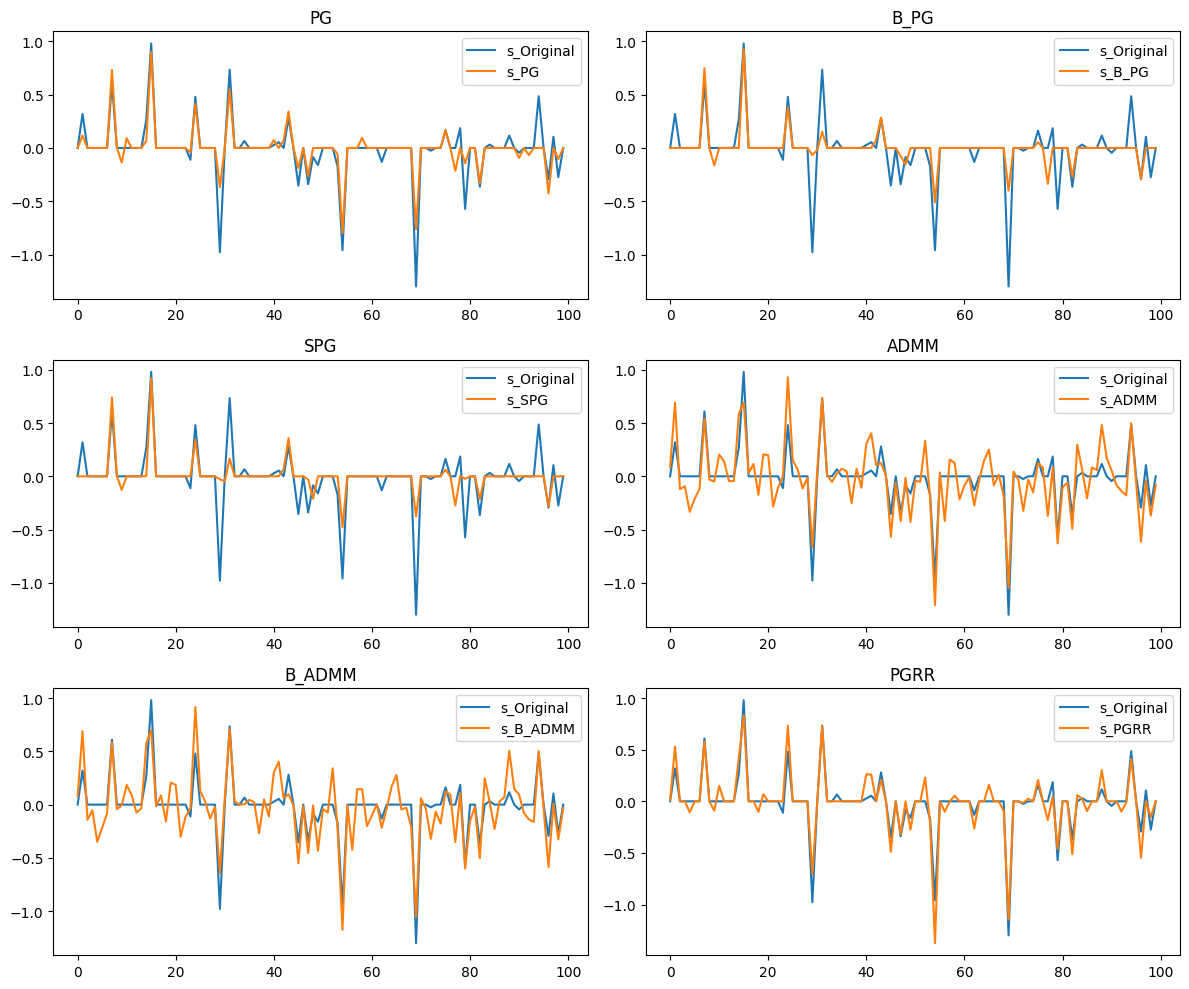

In [40]:
# 绘制重构信号
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# 第一张图
axs[0, 0].plot(s[idx], label='s_Original')
axs[0, 0].plot(s_pg, label='s_PG')
axs[0, 0].set_title('PG')
axs[0, 0].legend()

# 第二张图
axs[0, 1].plot(s[idx], label='s_Original')
axs[0, 1].plot(s_bpg, label='s_B_PG')
axs[0, 1].set_title('B_PG')
axs[0, 1].legend()

# 第三张图
axs[1, 0].plot(s[idx], label='s_Original')
axs[1, 0].plot(s_spg, label='s_SPG')
axs[1, 0].set_title('SPG')
axs[1, 0].legend()

# 第四张图
axs[1, 1].plot(s[idx], label='s_Original')
axs[1, 1].plot(s_admm, label='s_ADMM')
axs[1, 1].set_title('ADMM')
axs[1, 1].legend()

# 第五张图
axs[2, 0].plot(s[idx], label='s_Original')
axs[2, 0].plot(s_badmm, label='s_B_ADMM')
axs[2, 0].set_title('B_ADMM')
axs[2, 0].legend()

# 第六张图
axs[2, 1].plot(s[idx], label='s_Original')
axs[2, 1].plot(s_pgrr, label='s_PGRR')
axs[2, 1].set_title('PGRR')
axs[2, 1].legend()

plt.tight_layout()
plt.savefig('./fig/Reconstructed_Signal_1.pdf', format='pdf')
plt.savefig('./fig/Reconstructed_Signal_1.eps', format='eps')
plt.show()


Assigning font /b'F1' = 'c:\\Users\\fangy\\miniconda3\\envs\\carla\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'


Embedding font c:\Users\fangy\miniconda3\envs\carla\lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans.ttf.
Writing TrueType font.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


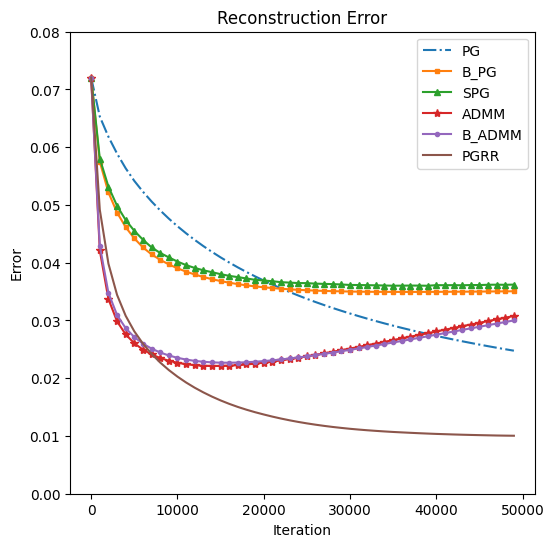

In [82]:
# 绘制误差曲线
plt.figure(figsize=(6, 6))
len_s = 50000

marker_styles = ['.', 's', '^', '*', 'o', '']

# 选择每隔 10 个数据点绘制一次
skip_interval = 1000

plt.plot(np.arange(len_s)[::skip_interval], e_pg[:len_s][::skip_interval], '-'+marker_styles[0], label='PG')
plt.plot(np.arange(len_s)[::skip_interval], e_bpg[:len_s][::skip_interval], '-'+marker_styles[1], markersize=3, label='B_PG')
plt.plot(np.arange(len_s)[::skip_interval], e_spg[:len_s][::skip_interval], '-'+marker_styles[2], markersize=4, label='SPG')
plt.plot(np.arange(len_s)[::skip_interval], e_admm[:len_s][::skip_interval], '-'+marker_styles[3], label='ADMM') 
plt.plot(np.arange(len_s)[::skip_interval], e_badmm[:len_s][::skip_interval], '-'+marker_styles[4], markersize=3,label='B_ADMM')
plt.plot(np.arange(len_s)[::skip_interval], e_pgrr[:len_s][::skip_interval], '-'+marker_styles[5], label='PGRR')


plt.legend()
plt.title('Reconstruction Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.ylim(0, 0.08)
plt.savefig('./fig/Reconstruction_Error_1.pdf', format='pdf')
plt.savefig('./fig/Reconstruction_Error_1.eps', format='eps')
plt.show()

Assigning font /b'F1' = 'c:\\Users\\fangy\\miniconda3\\envs\\carla\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'


Embedding font c:\Users\fangy\miniconda3\envs\carla\lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans.ttf.
Writing TrueType font.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


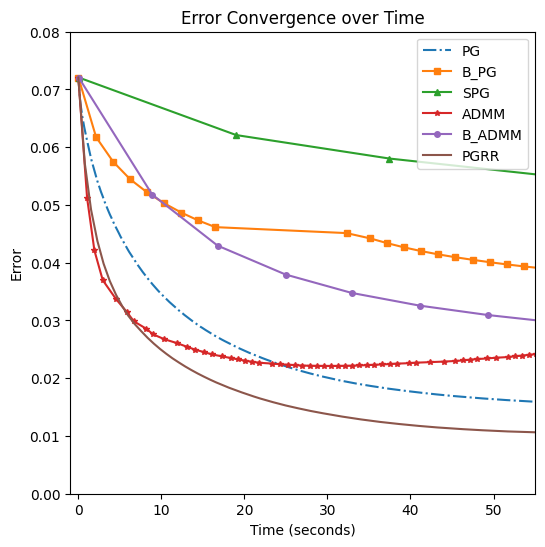

In [91]:
# 绘制图像
plt.figure(figsize=(6, 6))

marker_styles = ['.', 's', '^', '*', 'o', '']

skip_interval = 500

algorithms = {
    'PG': [t_pg, e_pg],
    'B_PG': [t_bpg, e_bpg],
    'SPG': [t_spg, e_spg],
    'ADMM': [t_admm, e_admm],
    'B_ADMM': [t_badmm, e_badmm],
    'PGRR': [t_pgrr, e_pgrr]
}

for i, (algorithm, data) in enumerate(algorithms.items()):
    t_modified = data[0][::skip_interval]
    e_modified = data[1][::skip_interval]
    plt.plot(t_modified, e_modified, '-'+marker_styles[i], label=algorithm, markersize=4)

plt.xlabel('Time (seconds)')
plt.ylabel('Error')
plt.title('Error Convergence over Time')
plt.legend()
plt.xlim(-1, 55)  # 设置x轴范围
plt.ylim(0, 0.08)  # 设置y轴范围
plt.savefig('./fig/Reconstruction_Error_Time_1.pdf', format='pdf')
plt.savefig('./fig/Reconstruction_Error_Time_1.eps', format='eps')
plt.show()

c:\Users\fangy\miniconda3\envs\carla\lib\site-packages\ipykernel_launcher.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
Assigning font /b'F1' = 'c:\\Users\\fangy\\miniconda3\\envs\\carla\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'
Embedding font c:\Users\fangy\miniconda3\envs\carla\lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans.ttf.
Writing TrueType font.


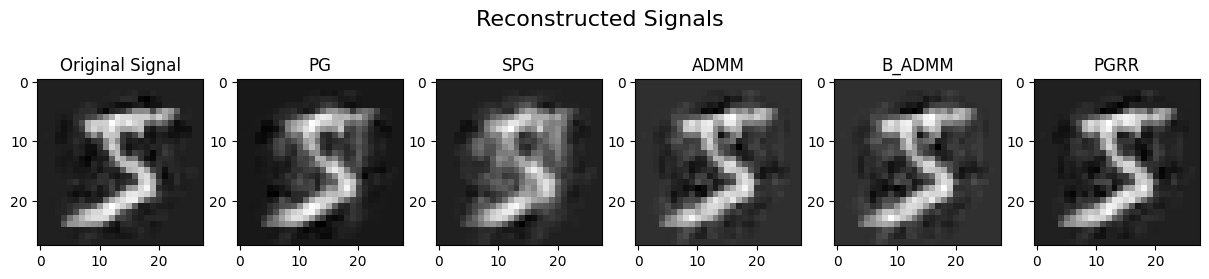

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# 创建子图
fig, axs = plt.subplots(1, 6, figsize=(15, 5), gridspec_kw={'hspace': 0.1})

# 第一个代码块
x = np.dot(Phi, u)
axs[0].imshow(x.reshape(28, 28), cmap='gray')
axs[0].set_title('Original Signal')

# 后续代码块
for i in range(1, 6):
    # 获取当前的重构信号
    reconstructed_signal = np.dot(Phi, [s_pg, s_spg, s_admm, s_badmm, s_pgrr][i-1])
    
    axs[i].imshow(reconstructed_signal.reshape(28, 28), cmap='gray')
    axs[i].set_title(f'{["PG", "SPG", "ADMM", "B_ADMM", "PGRR"][i-1]}')

# 使用plt.suptitle创建子图标题
plt.suptitle('Reconstructed Signals', y=0.8, fontsize=16)

# 保存图形
plt.tight_layout()
plt.savefig('./fig/Reconstructed_Signal_1.pdf', format='pdf')
plt.savefig('./fig/Reconstructed_Signal_1.eps', format='eps')
plt.show()
